author: leezeeyee   
date: 2021/4/15    
link: [github](https://github.com/easilylazy/pattern-recognition) 

initial: can't using solve_qp in qpsolevers: Q should be positive     
因为把svm转化成QP问题时构造的矩阵不是正定的，但增加一个近似0的偏置数据即可解决


In [1]:
from numpy import array, dot
from qpsolvers import solve_qp

M = array([[1., 2., 0.], [-8., 3., 2.], [0., 1., 1.]])
P = dot(M.T, M)  # this is a positive definite matrix
q = dot(array([3., 2., 3.]), M).reshape((3,))
G = array([[1., 2., 1.], [2., 0., 1.], [-1., 2., -1.]])
h = array([3., 2., -2.]).reshape((3,))
A = array([1., 1., 1.])
b = array([1.])

x = solve_qp(P, q, G, h, A, b)
print("QP solution: x = {}".format(x))

QP solution: x = [ 0.30769231 -0.69230769  1.38461538]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import qpsolvers

## QP solver
![](./qp.jpg)     


$$
\begin{equation}
\begin{array}{ll}
\underset{x}{\operatorname{minimize}} & \frac{1}{2} x^{T} P x+q^{T} x \\
\text { subject to } & G x \leq h \\
& A x=b \\
& l b \leq x \leq u b
\end{array}
\end{equation}
$$

In [3]:
def addSingleBias(X):
    N=X.shape[0]
    X=np.reshape(X,[N,1])
    bias_vector=np.ones([1,1])
    return np.row_stack((bias_vector,X))
def addBias(X):
    '''
    为维数为N,d的向量X添加偏置向量
    Args:
        X(numpy.ndarray):shape为[N,d]
    Returns:
        numpy.ndarray:shape为[N,d+1]，且第一列列向量全为1
    '''
    
    try:
        N=X.shape[0]
        d=X.shape[1]
        if d == 1:
            return addSingleBias(X)
        bias_vector=np.ones([N,1])
        return np.column_stack((bias_vector,X))
        
    except:
        return addSingleBias(X)

## loadData

In [7]:
#中国沿海城市的坐标集
X1 = np.array([
    [119.1,34.4],
    [121.3,29.5],
    [120.2,36.1],
    [119.4,39.6],
    [113.5,22.3],
    [118.1,24.5],
    [121.4,34.5],
    [114.1,22.6],
    [110.1,20.3],
    [123.3,38.6],
    [117.2,39.1]])
X1_add = np.array([
    [114,30],
    [116,24],
    [117,32]])
#日本沿海城市的坐标集
X2 = np.array([
    [130.3,32.3],
    [130.6,33.6],
    [139.4,35.3],
    [135.1,34.4],
    [136.6,35.1],
    [130.4,33.6],
    [132.3,34.2],
    [130.5,33.4],
    [129.9,32.8],
    [135.3,34.4],
    [139.5,35.4]])
X2_add = np.array([
    [141,38],
    [138,36],
    [135,35]])
island=np.asarray([123,25])
D=np.r_[X1,X2]
Y=np.r_[np.ones([len(X1),1]),-np.ones([len(X2),1])]
D_add=np.r_[X1,X1_add,X2,X2_add]
Y=np.r_[np.ones([len(X1),1]),-np.ones([len(X2),1])]
Y_add=np.r_[np.ones([len(X1)+len(X1_add),1]),-np.ones([len(X2)+len(X2_add),1])]

## basic 
原始数据，皆为临海城市

In [22]:
d=2
I=np.eye(d)
smallBias=1e-6
Q= np.block([[smallBias,smallBias*np.ones([1,d])],
                [smallBias*np.ones([d,1]),I]])
p=np.zeros(d+1)

In [23]:
A=-np.multiply(addBias(D),Y)
C=-np.ones(len(A))

In [24]:
x = solve_qp(Q, p, A, C)#G, h, A, b)
# solve_qp(solver= CVXOPT, OSQP and quadprog))
print("QP solution: x = {}".format(x))

QP solution: x = [30.16075914 -0.25397711  0.05581915]


In [25]:
x

array([30.16075914, -0.25397711,  0.05581915])

### support vector

In [28]:
np.dot(x,addBias(D).transpose())

array([ 1.83226347,  1.        ,  1.64778119,  2.04632989,  2.57912364,
        1.53363104,  1.25369802,  2.44348311,  3.33100754,  1.        ,
        2.57716997, -1.12950042, -1.13312866, -3.27323472, -2.23137036,
       -2.57326263, -1.08233324, -1.53139827, -1.11889478, -1.        ,
       -2.28216578, -3.29305052])

In [34]:
support_vector_site=np.where(np.abs(np.abs(np.dot(x,addBias(D).transpose()))-1)<=1e-6)[0]
for site in support_vector_site:
    print(D[site])

[121.3  29.5]
[123.3  38.6]
[129.9  32.8]


### result

In [26]:
print(np.dot(x,addBias(island)))
if np.dot(x.transpose(),addBias(island))>0:
    print('China')
else:
    print('Japan')

[0.31705275]
China


### display

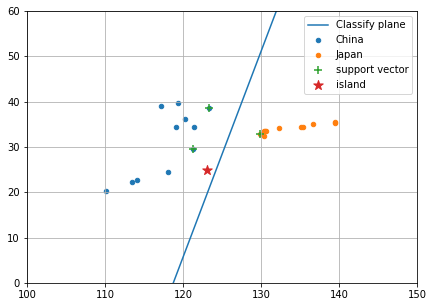

In [55]:
class Point():
    def __init__(self,x,y):
        self.x=x
        self.y=y
W1=x.reshape(3)
# print(W1)
k=-W1[1]/W1[2]
b=-W1[0]/W1[2]
scale=1000

plt.figure(figsize=(7,5))
P1=Point(scale,k*scale+b)
P2=Point(-scale,-k*scale+b)
plt.scatter(D[:len(X1),0],D[:len(X1),1],marker = 'o', s=20, cmap = plt.cm.Spectral)
plt.scatter(D[len(X1):,0],D[len(X1):,1],marker = 'o', s=20, cmap = plt.cm.Spectral)
plt.scatter(D[support_vector_site][:,0],D[support_vector_site][:,1],marker = '+', s=50, cmap = plt.cm.Spectral)
plt.scatter(island[0],island[1],marker = '*', s=100, cmap = plt.cm.Spectral)
plt.plot([P1.x,P2.x],[P1.y,P2.y],'-')
plt.legend(['Classify plane','China','Japan','support vector','island'])
plt.grid(True)
plt.xlim((100, 150))
plt.ylim((0, 60))   
plt.show()

## pro
增加非沿海城市数据

In [43]:
d=2
I=np.eye(d)
smallBias=1e-6
Q= np.block([[smallBias,smallBias*np.ones([1,d])],
                [smallBias*np.ones([d,1]),I]])
p=np.zeros(d+1)

In [44]:
A=-np.multiply(addBias(D_add),Y_add)
C=-np.ones(len(A))

In [45]:
x = solve_qp(Q, p, A, C)#G, h, A, b)
# solve_qp(solver= CVXOPT, OSQP and quadprog))
print("QP solution: x = {}".format(x))

QP solution: x = [30.16075914 -0.25397711  0.05581915]


### support vector

In [46]:
support_vector_site=np.where(np.abs(np.abs(np.dot(x,addBias(D).transpose()))-1)<=1e-6)[0]
for site in support_vector_site:
    print(D[site])

[121.3  29.5]
[123.3  38.6]
[129.9  32.8]


### result

In [47]:
print(np.dot(x,addBias(island)))
if np.dot(x.transpose(),addBias(island))>0:
    print('China')
else:
    print('Japan')

[0.31705275]
China


### display

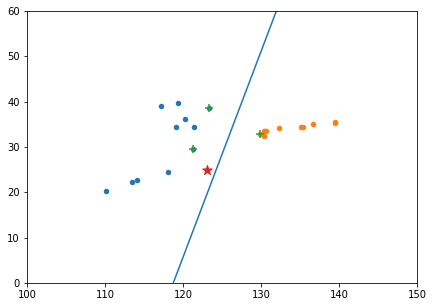

In [48]:
class Point():
    def __init__(self,x,y):
        self.x=x
        self.y=y
W1=x.reshape(3)
# print(W1)
k=-W1[1]/W1[2]
b=-W1[0]/W1[2]
scale=1000

plt.figure(figsize=(7,5))
P1=Point(scale,k*scale+b)
P2=Point(-scale,-k*scale+b)
plt.scatter(D[:len(X1),0],D[:len(X1),1],marker = 'o', s=20, cmap = plt.cm.Spectral)
plt.scatter(D[len(X1):,0],D[len(X1):,1],marker = 'o', s=20, cmap = plt.cm.Spectral)
plt.scatter(D[support_vector_site][:,0],D[support_vector_site][:,1],marker = '+', s=50, cmap = plt.cm.Spectral)
plt.scatter(island[0],island[1],marker = '*', s=100, cmap = plt.cm.Spectral)
plt.plot([P1.x,P2.x],[P1.y,P2.y],'-')
plt.xlim((100, 150))
plt.ylim((0, 60))   
plt.show()